<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/7_multi_model_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Multiplotting Function

In [ ]:
def multi_model_plotting(timeseries, paths_to_forecasts, model_names, variable):
    """
    Plots the predictions of multiple models on a single plot.
    
    Parameters:
    timeseries (np.ndarray): The full timeseries data, including context and ground truth.
    paths_to_forecasts (list of str): List of paths to the CSV files containing model predictions. The CSV files should contain two columns: 'timepoints' and 'forecast'.
    model_names (list of str): List of names corresponding to each model.
    variable (str): The name of the variable being predicted (for labeling purposes).
    """
    
    timeseries_length = len(timeseries)

    # initialize plot with width proportional to timeseries length
    base_width = 10
    width = max(base_width, int(timeseries_length / 18))
    plt.figure(figsize=(width, 12))

    # Define a color map for different models
    colors = plt.cm.get_cmap('tab10', len(paths_to_forecasts))
    predicted_timepoints_ind = np.zeros((timeseries_length,))
    # Define a list of markers for each model
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', '<', '>']
    for i, (path, model_name) in enumerate(zip(paths_to_forecasts, model_names)):
        # load predictions
        forecasts = pd.read_csv(path)
        predicted_future = forecasts['forecast'].to_list()
        predicted_timepoints = forecasts['timepoints'].to_list()

        # keep track of which timepoints were predicted
        predicted_timepoints_ind[predicted_timepoints] = 1

        # plot predictions with color
        m = markers[i % len(markers)]
        plt.plot(predicted_timepoints, predicted_future, label=f"{model_name} Prediction", linestyle="--", marker=m, color=colors(i))
    

    # plot context and actual future based on which timepoints were predicted
    # since we do not want to assume which timepoints were used as context and as ground truth, we plot based on indices of predicted timepoints    
    all_timepoints = np.arange(timeseries_length)

    # plot context
    context_values = timeseries[predicted_timepoints_ind == 0]
    context_timepoints = all_timepoints[predicted_timepoints_ind == 0]
    plt.plot(context_timepoints, context_values, label="Context", color="black", marker='o', linestyle="-", linewidth=4)

    # plot ground truth
    ground_truth_values = timeseries[predicted_timepoints_ind == 1]
    ground_truth_timepoints = all_timepoints[predicted_timepoints_ind == 1]
    plt.plot(ground_truth_timepoints, ground_truth_values, label="Ground Truth", color="lightgray", linestyle="--", linewidth=2)


    plt.title(f"Forecasting with Multiple Models")
    plt.xlabel("Time Step")
    plt.ylabel(variable)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Evaluating Different Given Models

C:\Users\ameri\AppData\Local\Temp\ipykernel_8644\1014323696.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(paths_to_forecasts))


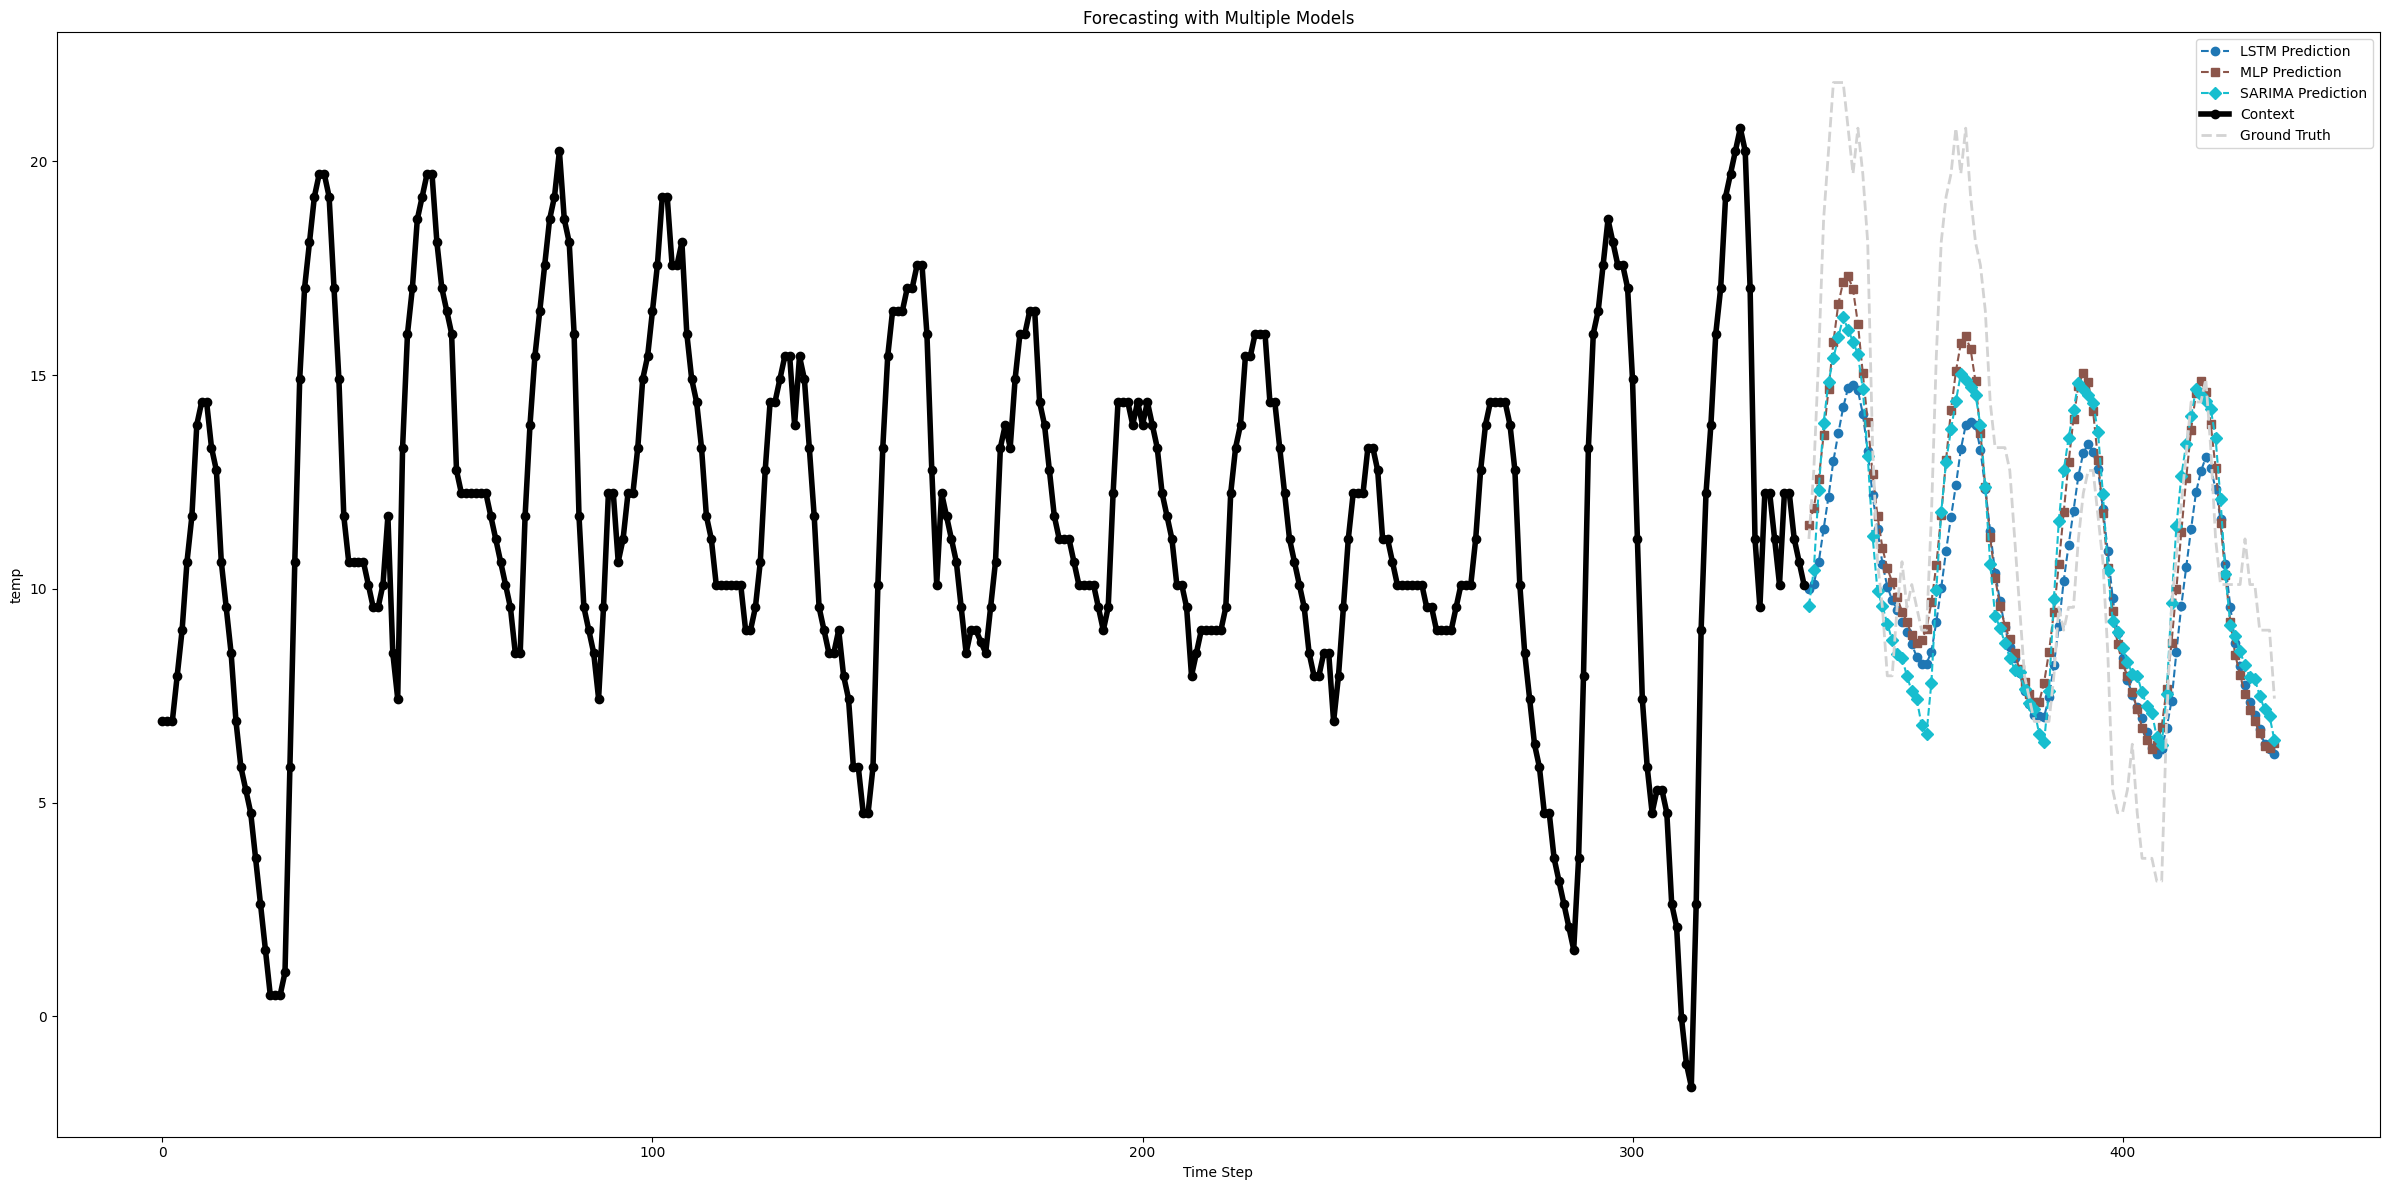

In [44]:
predicted_paths = [
    "model_results/LSTM_forecast.csv",
    "model_results/MLP_forecast.csv",
    "model_results/sarima_forecast.csv",
]

model_names = ["LSTM", "MLP", "SARIMA"]
variable = "temp"
results_sample = np.load("results_timeseries.npy", allow_pickle=True)

multi_model_plotting(results_sample, predicted_paths, model_names, variable)

As can be seen in the plot, the different models perform very similarly on the given sample. All models fail to capture the ground-truth trends. Surprisingly, the LSTM predicitions seem the worst among the tested models. This may be due to the training for the LSTM not being optimal (i.e. the model was not trained until optimality with meta- and hyperparameter tuning). This may have resulted in the smaller MLP learning better than the much larger LSTM.

Given that all predictions were obtained with the same context-window and prediction-window, the full benefits of the above implementation are not seen with this plot.

# Comparison Task 3